In [ ]:
import pandas as pd
import io
import pandas as pd
import re
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
df = pd.read_csv('/content/drive/MyDrive/AI/city_marks_data.csv')
cent_data = pd.read_csv('/content/drive/MyDrive/AI/cent_data.csv')

high_scorers = df[df['Marks'] > 718]
high_scorers.size

183

In [ ]:
# 1. Data Overview
print(df.describe())
city_counts = df['City'].value_counts()
print("Number of unique cities:", len(city_counts))
print("Top 10 cities by number of students:")
print(city_counts.head(10))
print("\nBottom 10 cities by number of students:")
print(city_counts.tail(10))


              Srlno         Marks          City
count  2.333301e+06  2.333301e+06  2.333301e+06
mean   2.903921e+02  2.171512e+02  3.224029e+05
std    2.724733e+02  1.662403e+02  1.049589e+05
min    1.000000e+00 -1.800000e+02  1.101010e+05
25%    1.240000e+02  8.700000e+01  2.602020e+05
50%    2.510000e+02  1.630000e+02  3.111190e+05
75%    4.080000e+02  3.130000e+02  4.122060e+05
max    1.780630e+05  7.200000e+02  9.914010e+05
Number of unique cities: 4750
Top 10 cities by number of students:
City
220701    1968
220501    1836
150201    1746
271201    1738
460308    1695
411001    1555
281201    1492
410101    1459
200159    1442
141501    1428
Name: count, dtype: int64

Bottom 10 cities by number of students:
City
390620    95
320123    95
362504    90
262201    76
330301    62
991401    53
990801    21
990901    14
990501     9
990401     8
Name: count, dtype: int64


In [ ]:
# 2. City-level Statistics
city_stats = df.groupby('City').agg({
    'Marks': ['count', 'mean', 'std', 'min', 'max'],
    'Srlno': 'count'
}).reset_index()
city_stats.columns = ['City', 'Student_Count', 'Mean_Marks', 'Std_Marks', 'Min_Marks', 'Max_Marks', 'Srlno_Count']

In [ ]:
# 3. Identify Potential Outliers
z_score = 3

def calculate_z_scores(series):
    return (series - series.mean()) / series.std()

city_stats['Mean_Marks_Z_Score'] = calculate_z_scores(city_stats['Mean_Marks'])
suspicious_cities = city_stats[abs(city_stats['Mean_Marks_Z_Score']) > z_score]
print(f"Cities with unusual average marks (Z-score > {z_score} or < -{z_score}):")
print(suspicious_cities[['City', 'Student_Count', 'Mean_Marks', 'Mean_Marks_Z_Score']])


Cities with unusual average marks (Z-score > 3 or < -3):
        City  Student_Count  Mean_Marks  Mean_Marks_Z_Score
121   122801            404  371.935644            3.054039
122   122802            214  370.429907            3.025220
732   220301            594  369.409091            3.005682
758   220701           1968  374.992378            3.112544
931   230507            397  386.463476            3.332095
989   231509            264  406.340909            3.712538
3367  392307            715  377.753846            3.165397
3368  392308            703  383.065434            3.267058
3369  392309            713  376.481066            3.141036
3370  392310            716  376.966480            3.150327
3371  392311            716  377.400838            3.158640
3373  392313            714  375.284314            3.118131
3374  392314            714  377.676471            3.163916
3375  392315            668  381.419162            3.235549
3376  392316            597  384.797320    

In [105]:
# 4.1 Variance Analysis (high)
variance_h = 2.1
city_stats['Variance_Z_Score'] = calculate_z_scores(city_stats['Std_Marks'])
high_variance_cities = city_stats[city_stats['Variance_Z_Score'] > variance_h]
print(f"Cities with unusually high variance in marks (Z-score > {variance_h}):")
print(high_variance_cities[['City', 'Student_Count', 'Std_Marks', 'Variance_Z_Score']])

Cities with unusually high variance in marks (Z-score > 2.1):
        City  Student_Count   Std_Marks  Variance_Z_Score
680   200217            266  206.025421          2.219761
913   230210            271  207.748736          2.294294
965   231105            448  206.279373          2.230744
1179  260105            115  203.738228          2.120839
1684  280702            670  203.768376          2.122143
1706  280724            344  207.152778          2.268519
1712  280730            183  207.529731          2.284822
1713  280731            386  203.749992          2.121348
2861  360425            492  204.198453          2.140744


In [102]:
# 4.2 Variance Analysis (low)
variance_l = 0.004
city_stats['Variance_Z_Score'] = calculate_z_scores(city_stats['Std_Marks'])
low_variance_cities = city_stats[abs(city_stats['Variance_Z_Score']) < variance_l]
print(f"Cities with unusually low variance in marks (Z-score < {variance_l}):")
print(low_variance_cities[['City', 'Student_Count', 'Std_Marks', 'Variance_Z_Score']])

Cities with unusually low variance in marks (Z-score < 0.004):
        City  Student_Count   Std_Marks  Variance_Z_Score
398   152101            797  154.784856          0.003599
624   200153            469  154.790523          0.003844
1065  241004            238  154.785111          0.003610
1124  250227            308  154.657163         -0.001924
1876  281607            264  154.780471          0.003409
2571  311601            750  154.670374         -0.001352
2577  311607            421  154.696491         -0.000223
3515  410811            715  154.782386          0.003492
3548  411103            497  154.633287         -0.002956
4468  450104            707  154.719142          0.000757
4651  461307            423  154.732566          0.001338


In [106]:
# # 5. Correlation Analysis (not usefull now)
# def srlno_marks_correlation(group):
#     return pd.Series({'Srlno_Marks_Correlation': group['Srlno'].corr(group['Marks'])})

# correlations = df.groupby('City').apply(srlno_marks_correlation).reset_index()
# city_stats = city_stats.join(correlations.set_index('City'), on='City')
# suspicious_correlations = city_stats[abs(city_stats['Srlno_Marks_Correlation']) > 0.5]
# print("Cities with high correlation between Serial Number and Marks (|correlation| > 0.5):")
# print(suspicious_correlations[['City', 'Student_Count', 'Srlno_Marks_Correlation']])

In [107]:
# 6. High Scorer Analysis
high_scorers = df[df['Marks'] > 700]
cities_with_high_scorers = high_scorers.groupby('City').agg({
    'Srlno': 'count',
    'Marks': ['min', 'max', 'mean']
}).reset_index()

cities_with_high_scorers.columns = ['City', 'High_Scorer_Count', 'Min_High_Score', 'Max_High_Score', 'Mean_High_Score']

# Merge with city_stats to get total student count
cities_with_high_scorers = cities_with_high_scorers.merge(city_stats[['City', 'Student_Count']], on='City')

# Calculate proportion of high scorers
cities_with_high_scorers['High_Scorer_Proportion'] = cities_with_high_scorers['High_Scorer_Count'] / cities_with_high_scorers['Student_Count']

cities_with_high_scorers = cities_with_high_scorers.sort_values('High_Scorer_Proportion', ascending=False)

print("\nTop 20 Cities with highest proportion of students scoring more than 700 marks:")
print(cities_with_high_scorers[['City', 'Student_Count', 'High_Scorer_Count', 'High_Scorer_Proportion']].head(20))


Top 20 Cities with highest proportion of students scoring more than 700 marks:
       City  Student_Count  High_Scorer_Count  High_Scorer_Proportion
168  220107            679                  9                0.013255
634  380204            469                  6                0.012793
847  392344            357                  4                0.011204
236  230610            398                  4                0.010050
826  392320            501                  5                0.009980
782  390803            406                  4                0.009852
161  200224            102                  1                0.009804
243  231001            520                  5                0.009615
164  220103            754                  7                0.009284
211  230115            232                  2                0.008621
48   140805            232                  2                0.008621
342  271241            349                  3                0.008596
848  39234

In [108]:
# Calculate statistics for high scorer proportion
average_high_scorer_proportion = cities_with_high_scorers['High_Scorer_Proportion'].mean()
median_high_scorer_proportion = cities_with_high_scorers['High_Scorer_Proportion'].median()
std_dev_high_scorer_proportion = cities_with_high_scorers['High_Scorer_Proportion'].std()

print(f"\nAverage proportion of high scorers across all cities: {average_high_scorer_proportion:.4f}")
print(f"Median proportion of high scorers across cities: {median_high_scorer_proportion:.4f}")
print(f"Standard deviation of the proportion of high scorers: {std_dev_high_scorer_proportion:.4f}")


Average proportion of high scorers across all cities: 0.0028
Median proportion of high scorers across cities: 0.0022
Standard deviation of the proportion of high scorers: 0.0016


In [109]:
# Identify cities with significantly higher than average high scorer proportions
threshold = average_high_scorer_proportion + 3 * std_dev_high_scorer_proportion
cities_with_high_scorer_outliers = cities_with_high_scorers[cities_with_high_scorers['High_Scorer_Proportion'] > threshold]

print("\nCities with significantly higher than average high scorer proportions (more than 4 standard deviations above the mean):")
print(cities_with_high_scorer_outliers[['City', 'Student_Count', 'High_Scorer_Count', 'High_Scorer_Proportion']])


Cities with significantly higher than average high scorer proportions (more than 4 standard deviations above the mean):
       City  Student_Count  High_Scorer_Count  High_Scorer_Proportion
168  220107            679                  9                0.013255
634  380204            469                  6                0.012793
847  392344            357                  4                0.011204
236  230610            398                  4                0.010050
826  392320            501                  5                0.009980
782  390803            406                  4                0.009852
161  200224            102                  1                0.009804
243  231001            520                  5                0.009615
164  220103            754                  7                0.009284
211  230115            232                  2                0.008621
48   140805            232                  2                0.008621
342  271241            349             

In [110]:
# Calculate high scorer counts and proportions
high_scorer_data = cities_with_high_scorers.set_index('City')[['High_Scorer_Count', 'High_Scorer_Proportion']].to_dict('index')

# Add the columns to city_stats using a mapping
city_stats['High_Scorer_Count'] = city_stats['City'].map(lambda city: high_scorer_data.get(city, {}).get('High_Scorer_Count', 0))
city_stats['High_Scorer_Proportion'] = city_stats['City'].map(lambda city: high_scorer_data.get(city, {}).get('High_Scorer_Proportion', 0))


# Update the flag_suspicious function to include high scorer proportion information
def flag_suspicious(row):
    flags = []
    if abs(row['Mean_Marks_Z_Score']) > z_score:
        flags.append("Unusual average marks")
    if row['Variance_Z_Score'] > variance_h:
        flags.append("High variance in marks")
    if abs(row['Variance_Z_Score']) < variance_l:
        flags.append("Low variance in marks")
    if row['High_Scorer_Proportion'] > threshold: # Use the column with the correct suffix
        flags.append(f"Unusually high proportion of high scorers: {row['High_Scorer_Proportion']:.4f}")
    return ", ".join(flags) if flags else "No flags"

city_stats['Suspicious_Flags'] = city_stats.apply(flag_suspicious, axis=1)

# Print updated suspicious cities information
suspicious_cities = city_stats[city_stats['Suspicious_Flags'] != "No flags"].sort_values('Student_Count', ascending=False)
print("\nUpdated Top 20 suspicious cities by student count (including high scorer proportion information):")
print(suspicious_cities[['City', 'Student_Count', 'High_Scorer_Count', 'Mean_Marks', 'High_Scorer_Proportion', 'Suspicious_Flags']].head(20)) # Use the column with the correct suffix


Updated Top 20 suspicious cities by student count (including high scorer proportion information):
        City  Student_Count  High_Scorer_Count  Mean_Marks  \
758   220701           1968                  9  374.992378   
3505  410801           1017                  2  369.318584   
3409  392349           1001                  8  375.393606   
398   152101            797                  3  198.963614   
706   220103            754                  7  286.319629   
2571  311601            750                  0  190.536000   
3370  392310            716                  3  376.966480   
3371  392311            716                  2  377.400838   
3515  410811            715                  1  216.546853   
3367  392307            715                  4  377.753846   
3373  392313            714                  1  375.284314   
3374  392314            714                  3  377.676471   
3369  392309            713                  2  376.481066   
4468  450104            707      

In [111]:
# Visualization function
def plot_city_distribution(df, city, city_stats):
    plt.figure(figsize=(12, 6))

    # Plot the overall distribution
    sns.histplot(df['Marks'], kde=True, stat="density", alpha=0.5, color='gray', label='Overall')

    # Plot the city-specific distribution
    sns.histplot(df[df['City'] == city]['Marks'], kde=True, stat="density", alpha=0.5, color='blue', label=city)

    total_students = city_stats[city_stats['City'] == city]['Student_Count'].values[0]
    high_scorers = city_stats[(city_stats['City'] == city)]['High_Scorer_Count'].values[0]
    plt.title(f'Mark Distribution: {city} vs Overall (Total: {total_students}, High Scorers: {high_scorers})')
    plt.xlabel('Marks')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


In [112]:

# Plot histograms for each city with high scorer outliers
# for city in cities_with_high_scorer_outliers['City']:
#     plot_city_distribution(df, city, city_stats)

# # Plot overall distribution
# plt.figure(figsize=(12, 6))
# sns.histplot(df['Marks'], kde=True, color='gray')
# plt.title('Overall Mark Distribution')
# plt.xlabel('Marks')
# plt.ylabel('Count')
# plt.show()

# # Scatter plot of High Scorer Proportion vs Total Students
# plt.figure(figsize=(12, 6))
# plt.scatter(cities_with_high_scorers['Student_Count'], cities_with_high_scorers['High_Scorer_Proportion'])
# plt.xlabel('Total Number of Students')
# plt.ylabel('Proportion of High Scorers')
# plt.title('High Scorer Proportion vs Total Students')
# for i, txt in enumerate(cities_with_high_scorers['City']):
#     if cities_with_high_scorers.iloc[i]['High_Scorer_Proportion'] > threshold:
#         plt.annotate(txt, (cities_with_high_scorers.iloc[i]['Student_Count'], cities_with_high_scorers.iloc[i]['High_Scorer_Proportion']))
# plt.show()

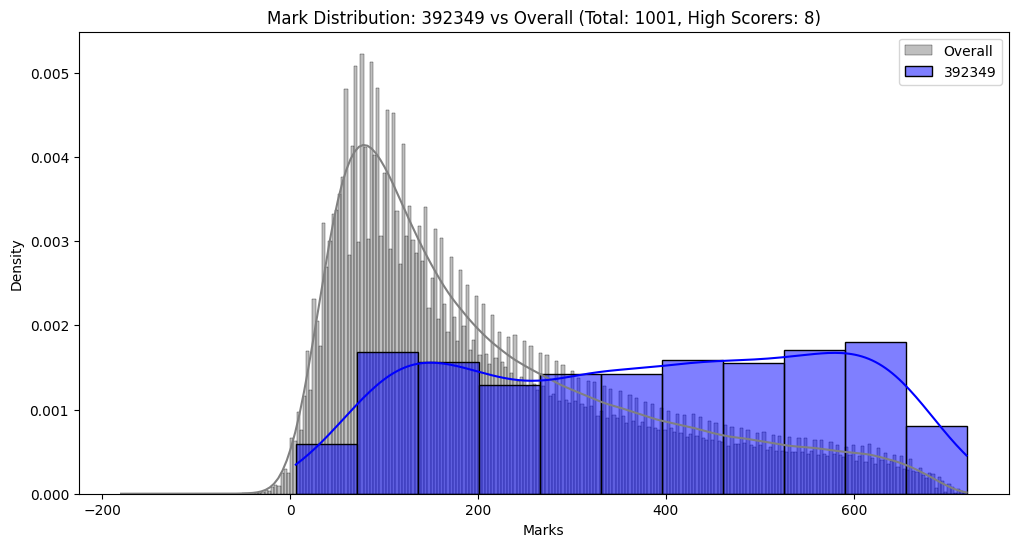

In [ ]:
plot_city_distribution(df, 392349, city_stats)

In [113]:
# prompt: lets print stats for each city, including variance, mean, high scores, write a function which takes a city

def print_city_stats(city, city_stats_df):
  """Prints statistics for a given city.

  Args:
    city: The name of the city.
    city_stats_df: The DataFrame containing city statistics.
  """

  city_data = city_stats_df[city_stats_df['City'] == city]
  if city_data.empty:
    print(f"No data found for city: {city}")
    return

  print(f"Statistics for {city}:")
  print(f"  Number of Students: {city_data['Student_Count'].values[0]}")
  print(f"  Mean Marks: {city_data['Mean_Marks'].values[0]:.2f}")
  print(f"  Standard Deviation of Marks: {city_data['Std_Marks'].values[0]:.2f}")
  print(f"  Minimum Marks: {city_data['Min_Marks'].values[0]}")
  print(f"  Maximum Marks: {city_data['Max_Marks'].values[0]}")
  print(f"  Number of High Scorers (Above 700): {city_data['High_Scorer_Count'].values[0]}")
  print(f"  Proportion of High Scorers: {city_data['High_Scorer_Proportion'].values[0]:.4f}")
  print(f"  Suspicious Flags: {city_data['Suspicious_Flags'].values[0]} (threshold: {threshold})")

# Example usage:
print_city_stats(392348, city_stats)


Statistics for 392348:
  Number of Students: 285
  Mean Marks: 353.33
  Standard Deviation of Marks: 192.89
  Minimum Marks: 6
  Maximum Marks: 710
  Number of High Scorers (Above 700): 2
  Proportion of High Scorers: 0.0070
  Suspicious Flags: No flags (threshold: 0.007519814251393468)


In [114]:
def print_city_stats_range(start_city, end_city, city_stats_df):
  """Prints statistics for cities within a given range and calculates aggregate statistics.

  Args:
    start_city: The starting city ID.
    end_city: The ending city ID.
    city_stats_df: The DataFrame containing city statistics.
  """

  cities_in_range = city_stats_df[(city_stats_df['City'] >= start_city) & (city_stats_df['City'] <= end_city)]
  if cities_in_range.empty:
    print(f"No data found for cities in the range: {start_city} to {end_city}")
    return

  # print(f"Statistics for cities in the range {start_city} to {end_city}:")
  # print(cities_in_range[['City', 'Student_Count', 'Mean_Marks', 'Std_Marks', 'High_Scorer_Count', 'High_Scorer_Proportion', 'Suspicious_Flags']])

  # Calculate aggregate statistics
  aggregate_stats = cities_in_range.agg({
      'Student_Count': 'sum',
      'Mean_Marks': 'mean',
      'Std_Marks': 'mean',
      'High_Scorer_Count': 'sum',
  })
  total_students = aggregate_stats['Student_Count']
  aggregate_high_scorer_proportion = aggregate_stats['High_Scorer_Count'] / total_students
  cities_with_high_scorer_outliers = cities_in_range[cities_in_range['High_Scorer_Proportion'] > threshold]

  print("\nAggregate Statistics:")
  print(f"  Total Students: {total_students}")
  print(f"  Total Cities: {len(cities_in_range)}")
  print(f"  Average Mean Marks: {aggregate_stats['Mean_Marks']:.2f}")
  print(f"  Average Standard Deviation of Marks: {aggregate_stats['Std_Marks']:.2f}")
  print(f"  Total High Scorers: {aggregate_stats['High_Scorer_Count']}")
  print(f"  Aggregate Proportion of High Scorers: {aggregate_high_scorer_proportion:.4f}")
  print(f"  Number of suspicious cities: {len(cities_with_high_scorer_outliers)}")

# Example usage:
print_city_stats_range(392301, 392349, city_stats)


Aggregate Statistics:
  Total Students: 27216.0
  Total Cities: 49
  Average Mean Marks: 367.77
  Average Standard Deviation of Marks: 192.53
  Total High Scorers: 104.0
  Aggregate Proportion of High Scorers: 0.0038
  Number of suspicious cities: 5


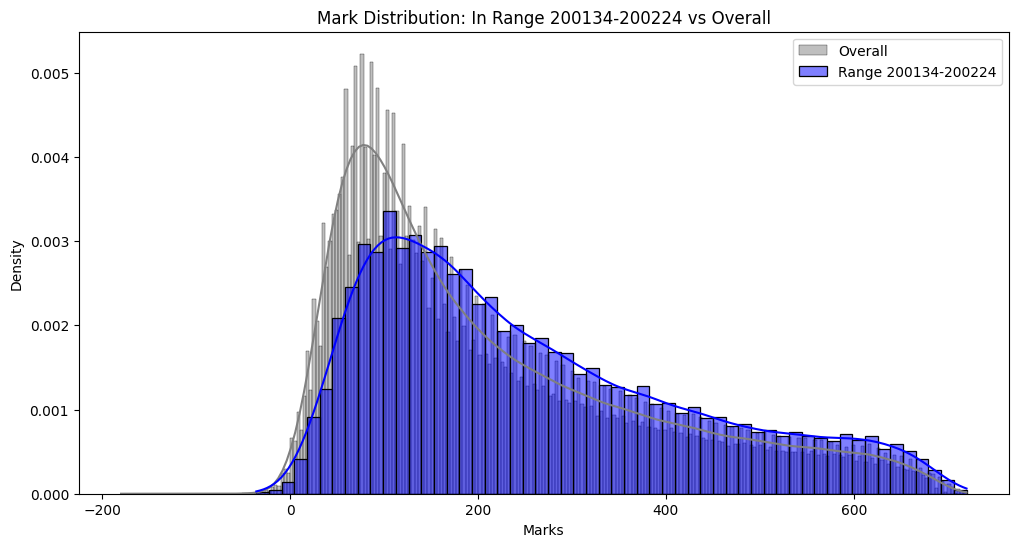


Aggregate Statistics:
  Total Students: 46163.0
  Total Cities: 83
  Average Mean Marks: 259.08
  Average Standard Deviation of Marks: 171.14
  Total High Scorers: 59.0
  Aggregate Proportion of High Scorers: 0.0013
  Number of suspicious cities: 2


In [115]:
def plot_city_in_range(df, start_city, end_city):
    plt.figure(figsize=(12, 6))

    # Plot the overall in
    sns.histplot(df['Marks'], kde=True, stat="density", alpha=0.5, color='gray', label='Overall')

    # Plot the city in_range
    sns.histplot(df[(df['City'] >= start_city) & (df['City'] <= end_city)]['Marks'], kde=True, stat="density", alpha=0.5, color='blue', label=f'Range {start_city}-{end_city}')
    plt.title(f'Mark Distribution: In Range {start_city}-{end_city} vs Overall')
    plt.xlabel('Marks')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

start_city = 200134
end_city = 200224
plot_city_in_range(df, start_city, end_city)
print_city_stats_range(start_city, end_city, city_stats)

In [84]:
marks_720_count = df[(df['Marks'] > 660) & (df['Marks'] < 711)]['Marks'].count()
print(f"Number of students with 720 marks: {marks_720_count}")

Number of students with 720 marks: 20562


In [116]:
# prompt: print all the suspicious cites

suspicious_cities = city_stats[city_stats['Suspicious_Flags'] != "No flags"].sort_values('Hi', ascending=False)
print("\nSuspicious cities by student count (including high scorer proportion information):")
print(suspicious_cities[['City','Suspicious_Flags']])
suspicious_centers = suspicious_cities[['City','Suspicious_Flags']].values[:,0]



Suspicious cities by student count (including high scorer proportion information):
        City                                   Suspicious_Flags
758   220701                              Unusual average marks
3505  410801                              Unusual average marks
3409  392349  Unusual average marks, Unusually high proporti...
398   152101                              Low variance in marks
706   220103  Unusually high proportion of high scorers: 0.0093
...      ...                                                ...
902   230115  Unusually high proportion of high scorers: 0.0086
122   122802                              Unusual average marks
1712  280730                             High variance in marks
1179  260105                             High variance in marks
687   200224  Unusually high proportion of high scorers: 0.0098

[84 rows x 2 columns]


In [137]:
# prompt: each City in suspicious_cities represents a CENTNO,, lets print corresponding CENT_STATE and CENT_CITY from cent_data, also prinf the flag, and sort in CENT_STATE

# Merge suspicious_cities with cent_data on 'City' (assuming it corresponds to 'CENTNO')
suspicious_centers_info = pd.merge(suspicious_cities[['City', 'Suspicious_Flags']],
                                   cent_data[['CENTNO', 'CENT_STATE', 'CENT_CITY']],
                                   left_on='City', right_on='CENTNO', how='left')

# Sort the result by 'CENT_STATE'
suspicious_centers_info_sorted = suspicious_centers_info.sort_values('CENT_STATE')

# Print the relevant information
display(suspicious_centers_info_sorted[['CENT_STATE', 'CENT_CITY', 'Suspicious_Flags']])


,CENT_STATE,CENT_CITY,Suspicious_Flags
80,ANDHRA PRADESH,TANUKU,Unusual average marks
57,ANDHRA PRADESH,TANUKU,Unusual average marks
78,ASSAM,DHUBRI,Unusually high proportion of high scorers: 0.0086
3,BIHAR,JEHANABAD,Low variance in marks
83,DELHI,DELHI/NEW DELHI,Unusually high proportion of high scorers: 0.0098
...,...,...,...
26,TAMIL NADU,NAMAKKAL,Unusual average marks
35,TAMIL NADU,THIRUVALLUR,Low variance in marks
27,TAMIL NADU,NAMAKKAL,Unusual average marks
13,UTTARAKHAND,DEHRADUN,Low variance in marks


In [165]:
# prompt: lets check correlation between Marks of  two different city, but before sort the Marks, also remove the indexing number, make it a function

def city_marks_correlation(df, city1, city2):
  """Calculates the correlation between the marks of two cities after sorting them.

  Args:
    df: The DataFrame containing the city and marks data.
    city1: The ID of the first city.
    city2: The ID of the second city.

  Returns:
    The correlation coefficient between the sorted marks of the two cities.
  """
  marks_city1 = df[df['City'] == city1]['Marks'].sort_values().reset_index(drop=True)
  marks_city2 = df[df['City'] == city2]['Marks'].sort_values().reset_index(drop=True)

  # Ensure both series have the same length for correlation calculation
  min_length = min(len(marks_city1), len(marks_city2))
  marks_city1 = marks_city1[:min_length]
  marks_city2 = marks_city2[:min_length]

  correlation = marks_city1.corr(marks_city2)
  return correlation

# Example usage:
city1_id = 392348
city2_id = 392349
correlation = city_marks_correlation(df, city1_id, city2_id)
print(f"Correlation between marks of city {city1_id} and city {city2_id}: {correlation:.4f}")


Correlation between marks of city 392348 and city 392349: 0.9910


In [ ]:
# prompt: now lets check correlation between Marks for all different cities

suspicious_centers_sorted = np.sort(suspicious_centers)

# Create a DataFrame to store correlations
city_correlations = pd.DataFrame(index=suspicious_centers_sorted, columns=suspicious_centers_sorted)

# Calculate correlations
for city1 in suspicious_centers:
  for city2 in suspicious_centers:
    correlation = city_marks_correlation(df, city1, city2)
    city_correlations.at[city1, city2] = correlation




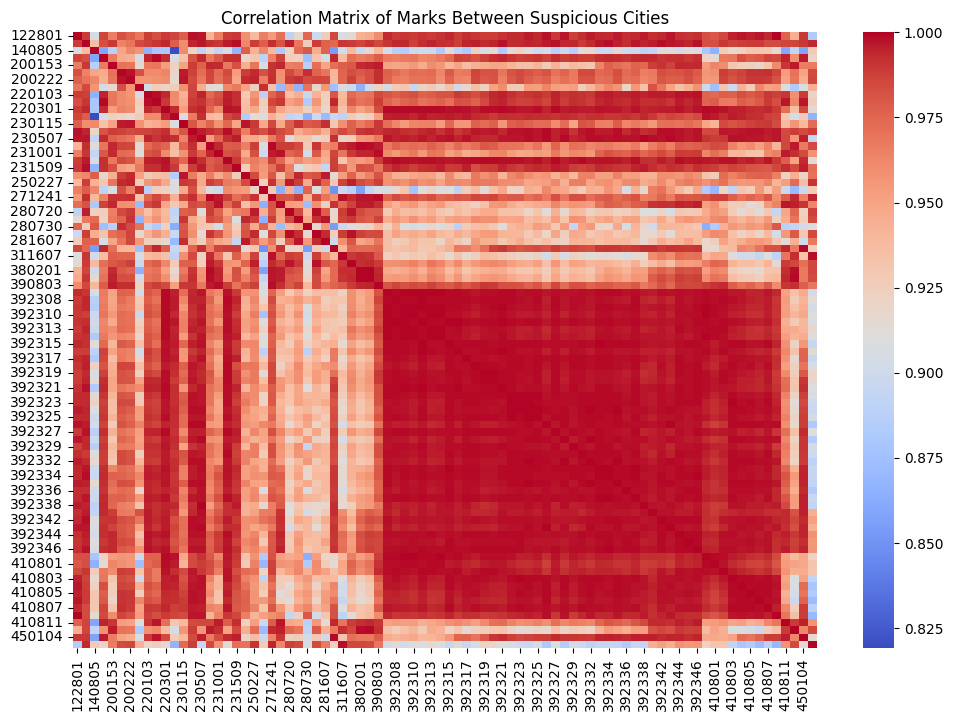

In [179]:
# Display the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(city_correlations.astype(float), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Marks Between Suspicious Cities')
plt.show()